# HCAIM CA3 - Human-Centric Deep Learning, Society & AI, Future of AI
Ben Johnson X00229603, Ravindra Sai Cherukuru X00229508, Rohith Budugarla X00229544, Sravan Kumar Yannam X00229546.

This research is in the domains of Medical Artificial Intelligence, Deep
Learning, Explainable Artificial Intelligence (XAI) & Medical Image Classification. The focus is on developing deep learning models for automated medical image classification (of lesions from CT scans) while ensuring trust, transparency & fairness using XAI techniques. The study is relevant to the fields of healthcare, computational medicine, and responsible AI
implementation in healthcare.

In this project, we used some data from the NIH Deep Lesion Dataset, and some data from Mendeley's "Abdominal CT scans" dataset. We collected the data in this way so that we could build a CNN to classify lesions within CT scans. We used various XAI tools throughout to maintain explainability and transparecy, such as Saliency Maps, and LIME.

Project Rationale: We chose to do this project in this field as it gives us a lot of scope to talk about compliance, regulation & legislation; We plan to use various XAI techniques to verify and support our findings, which should be easier to do as the dataset is related to such a sensitive topic. Additionally, we can discuss the EU AI Act, ethical concerns, data privacy & maintenance. Furthermore, we will conduct a comprehensive literature review in order to
discover the current trends, emerging tools and future aims of the sector. Following the literature review, we will develop & compare some machine learning techniques such as K-Nearest Neighbours and Logistic Regression, which will be helpful as a baseline when we come to the design and implementation of a neural network, which will also be evaluated both in terms of initial development and XAI.

Datasets:
*   https://data.mendeley.com/datasets/6x684vg2bg/1
*   https://www.kaggle.com/datasets/kmader/nih-deeplesion-subset/data



# Prerequisites

In [ ]:
!pip install tf-keras-vis lime tensorflow-model-optimization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Exploration

In [ ]:
# pre-processing libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import os
import time
import shutil
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from PIL import ImageOps, Image
import glob
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras import layers, Model, applications
from tensorflow.keras.applications import MobileNetV2
import tensorflow_model_optimization as tfmot
from tensorflow.keras.optimizers import Adam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter,Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import lime
from lime import lime_image

# figure sizes
plt.rcParams['figure.figsize'] = [5,5]
num_classes = 2 # classification classes
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# append images into lists (class1 - Abdomen CT scans with Lesions)
class1 = [Image.open(filename) for filename in glob.glob('/content/drive/MyDrive/ca3_data/abdomen_with_lesions/*.jpg')]

# load class0 (Abdomen CT scans without Lesions, original size 400+ images)
class0_files = glob.glob('/content/drive/MyDrive/ca3_data/abdomen_without_lesions/*.jpg')

# randomly select 146 images from class0
class0 = [Image.open(filename) for filename in random.sample(class0_files, 146)]

We have 146 images in each class. The low number is due to the fact that we combined datasets, and had to cut down to match, while also providing some validation data. We understand that this amount of data is not appropriate, but we had to continue with what we have.

In [ ]:
print("Class0 size:", len(class0))
print("Class1 size:", len(class1))

Class0 size: 146
Class1 size: 146


## 1.1 Image Size

In [ ]:
# function for displaying first 3 images
def display_images(list):
  for i in range(3):
    display(list[i])

First of all, we checked the size of the first image in each dataset to help us understand what we were working with. Each image is 512x512px in size, they are too large for the type of CNN we want to develop, given the timeframe and resources available, it will need to be resized.

We did run the code in full with images resized from 64x64 up to 512x512, and 128x128 proved to be the most suitable, as it never ran out of compute time and also maintained the most quality.

In [ ]:
def get_first_image_size(image_list):
  if len(image_list) > 0:
    return image_list[0].size
  else:
    return None

print("First Abdomen (without Lesion) image size:", get_first_image_size(class0))
print("First Abdomen (with Lesion) image size:", get_first_image_size(class1))

First Abdomen (without Lesion) image size: (512, 512)
First Abdomen (with Lesion) image size: (512, 512)


## 1.2 First three images

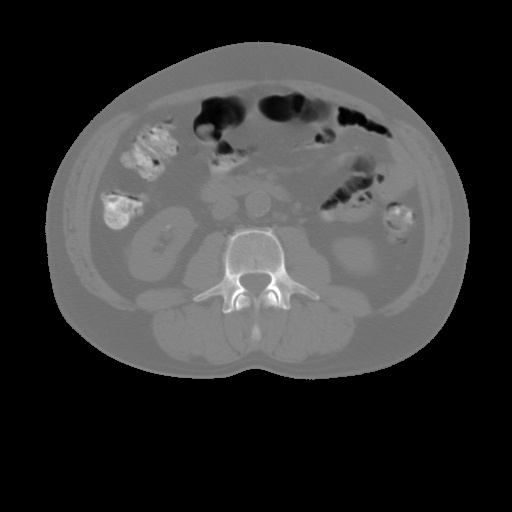

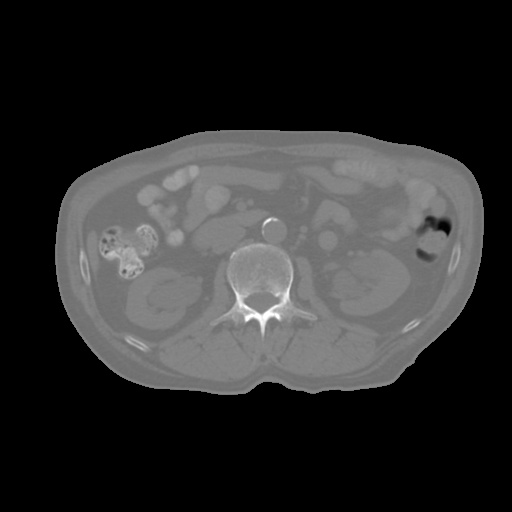

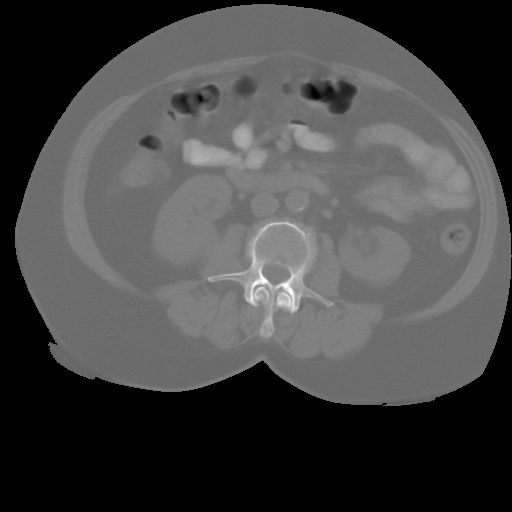

In [ ]:
# first 3 abdomen without lesions
display_images(class0)

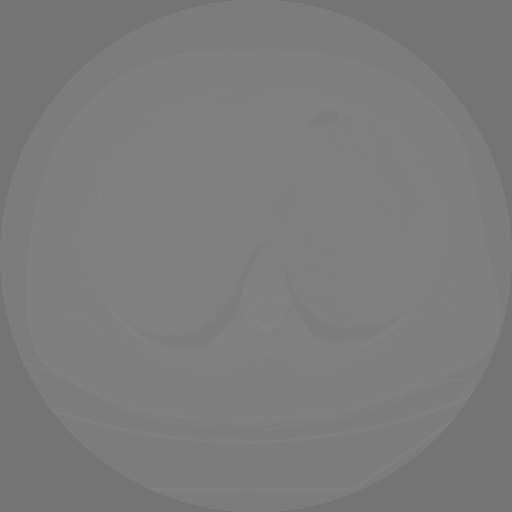

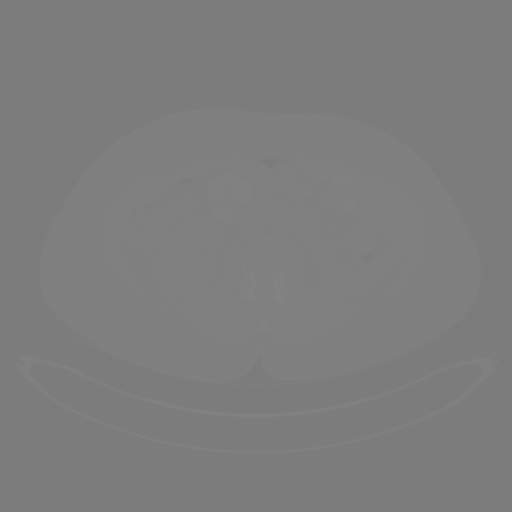

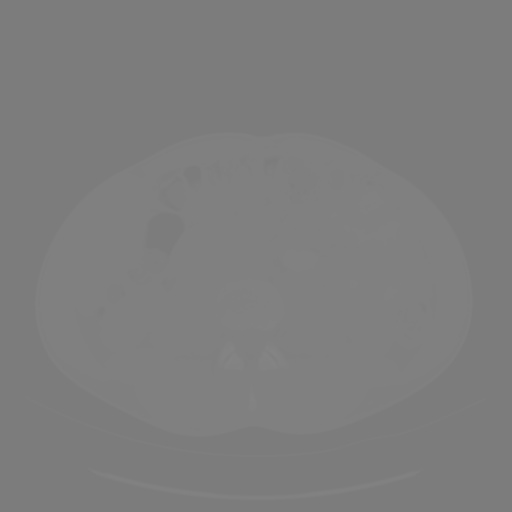

In [ ]:
# first 3 abdomen with lesions
display_images(class1)

After analysing the first three images in each dataset, and checking their sizes, we can clearly see that there is some preprocessing that needs to be done. The images are too large, and too high quality to be run in our proposed CNN and environment. The images need to be resized, scaled and recoloured / have contrast increased in order to develop a suitable, (hopefully!) accurate model.

At this stage we have some concerns over the correct identification of lesions, as we cannot see where exactly the lesions are. We have kept this is mind further on in the development.

## 1.3 Average of all images

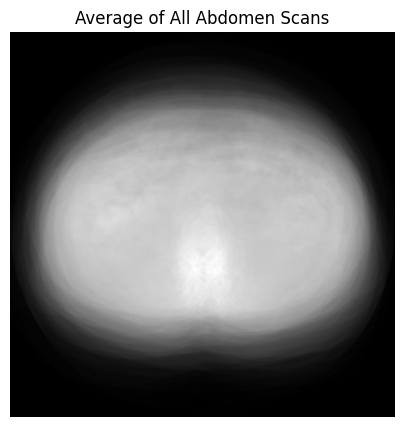

In [ ]:
# ensure class0 and class1 are numpy arrays
class0_copy = np.array(class0)
class1_copy = np.array(class1)

# calculate the mean image
mean_image = np.mean(np.concatenate((class0_copy, class1_copy), axis=0), axis=0)

# display the mean image
plt.figure(figsize=(5, 5))
plt.imshow(mean_image, cmap=cm.gray)
plt.axis('off')
plt.title('Average of All Abdomen Scans')
plt.show()

We knew that CT Scans were presented as black images, with the scanned organ / body part appearing generally in the centre, as a white or grey shape. This average image is just a quick sanity check.

## 1.4 Image edge detection

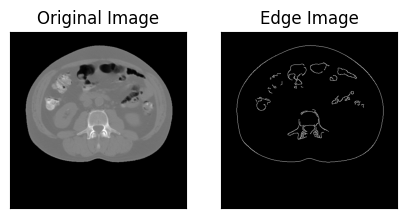

In [ ]:
def define_edges(image_list, x, y):
  img = image_list[0]
  img = img.astype(np.uint8)

  edges = cv2.Canny(img, x, y)

  plt.subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title('Original Image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(122)
  plt.imshow(edges, cmap='gray')
  plt.title('Edge Image')
  plt.xticks([])
  plt.yticks([])

  plt.show()

define_edges(class0_copy, 100, 200)

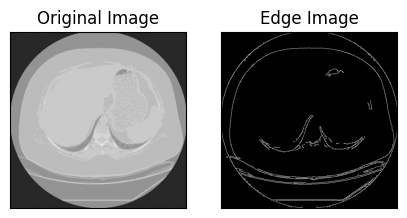

In [ ]:
define_edges(class1_copy, 5, 10)

We can see that the Canny edge detection algorithm (thresholds set at 100, 200 for class0 and 5, 10 for class1) highlights sharp changes in intensity, typically corresponding to edges or contours in the image. It is not ideal that we have to use different intensities just to see the main part of the image, as this could become a problem later in development.

## 1.5 Ethical Concerns
To assess **compliance** with legislation like the EU AI Act and GDPR, we examined the dataset and model for risks in fairness & explainability. A major risk is bias, as the datasets are different, and as you have seen, each class looks very different, additiionally, the data may lack demographic diversity, leading to unequal model performance. Explainability is another key requirement for high-risk AI (our lesion classifier is high risk as per the EU AI Act); CNNs are often black-box models, so tools like GradCAM are going to be used to make decisions more interpretable for clinicians and patients alike. Finally, to support transparency, we ensured all data sources, preprocessing steps, and model training processes are well-documented and covered in the accompanying paper. These steps help mitigate risk and align the system with ethical and legal standards.

Integrating AI ethics frameworks, like the EU AI Act, into the development of a CNN for abdominal lesion detection creates a foundation for evaluating and mitigating **ethical concerns** throughout the project. As mentioned previously, the EU AI Act categorizes medical AI systems as high-risk, which means they are subject to stricter regulatory requirements, including transparency, accountability, data governance, and human oversight. To follow the official guidelines, the use of the NIH DeepLesion and Mendeley Abdomen CT datasets required safe data handling, ensuring datasets were collected and shared ethically, with appropriate consent and anonymization. Furthermore, the Act emphasizes robustness and accuracy, requiring that models are trained and tested on diverse, representative data to minimize bias and ensure generalizable performance across different populations. Throughout this project, we have made sure that the data is anonymized and collected from trusted sources, provided in the first text block. Although these datasets are publicly available, there remains a risk of re-identification if combined with other data sources, a challenge that had to be actively managed.

The Act also aligns with broader AI ethics principles promoted by the European Commission's High-Level Expert Group on AI, which demand respect for human autonomy, prevention of harm, fairness, and explainability. These principles challenged us to go beyond technical performance of models, and to consider how the model's development & deployment might affect workflows, trust, and patient-clinician relationships. For example, explainability becomes a legal and ethical obligation, not just a design feature, it is particularly important when radiologists must interpret and act on model outputs. Additionally, human oversight must be built into any further development of the system, ensuring that clinicians maintain final decision-making authority, thus preserving professional accountability and ethical responsibility.

**Maintaining compliance** while leveraging AI in a medical imaging project like ours presents several practical challenges. For example, we had to balance model performance with explainability, which is a common trade-off in CNN architectures, as they are often black-box models. Meeting documentation and traceability requirements, such as logging tests, hyperparameter choices, and evaluation results are time-consuming but necessary under the EU AI Act's conformity assessments. We have made recordings of our meetings and have kept eachother constantly informed of our work. Moreover, the dynamic nature of medical data broadens the scope to model retraining over time, raising issues of continuous validation and monitoring that may need to be addressed through newer governance frameworks.

The **main risks** associated with this system include data privacy breaches, biased predictions, lack of transparency, and over-reliance on automated outputs. These risks could compromise compliance with current regulations, such as the EU AI Act, the GDPR, and medical device regulations. For example, a misdiagnosis caused by a biased model could trigger legal liability and reputational harm, especially if it can be shown that insufficient diversity or validation was built into the training data. To mitigate these risks, it is essential that human oversight remains central in any future model development, with clinicians retaining final decision-making authority. Our data is generally poor, and we did not want to spend time augmenting medical data, as CT scans are always exact and precise. Building detailed documentation, bias mitigation strategies, and model explainability mechanisms into the development lifecycle will be critical to ensuring long-term ethical and legal compliance. We have tried to aid in this by creating LIME and GradCAM visualizations of the predictions.

## 1.6 Potential Data Bias

While training a CNN to classify lesions using the Mendeley Abdominal CT Scans and NIH DeepLesion datasets, it is important to address potential biases that may affect model generalizability. The Mendeley dataset, focused on stomach cancer detection, contains axial CT scans from a single hospital in Iran, which risks geographic and demographic bias (like limited representation of age, sex, or ethnic diversity). Similarly, while the NIH DeepLesion dataset includes over 32,000 annotated lesions across diverse regions (bone, liver, kidney, etc.), its reliance on data from a single American institution raises concerns about data sourcing (for example, differences in CT protocols / scanner differences) and underrepresentation of rare lesion types or patient subgroups. Additionally, as we will be using a small subset of the data, we risk introducing sampling bias.

## 1.7 Data Preprocessing

The function `preprocess_and_save_images()` takes a list of PIL.Image objects, folder location and size, and applies a loop of:

*   Resizing images to 128x128
*   Converting to greyscale
*   Contrast enhancement by redistributing pixel intensities (`.equalize()`)
*   Normalization of pixel values.
*   Saves the processed images as `.png` with filename `image_i.png`.

The images are saved into "clean" class folders and later used in model training and testing. We did test images in 64x64 up to 512x512 pixel size, but the image quality was too blurry, or we ran out of resources, which is obviously detrimental to sensitive medical data like ours.



In [ ]:
os.makedirs('abdomen_with_lesion_preprocessed', exist_ok=True)
os.makedirs('abdomen_without_lesion_preprocessed', exist_ok=True)

def preprocess_and_save_images(image_list, folder_name, size=(128, 128)):
    processed = []
    for i, img in enumerate(image_list):
        img = img.resize(size)
        img = img.convert('L')
        img = ImageOps.equalize(img)
        img_arr = np.array(img) / 255.0
        processed.append(img_arr)

        # save the preprocessed images
        save_path = os.path.join(folder_name, f'image_{i}.png')
        Image.fromarray((img_arr * 255).astype(np.uint8)).save(save_path)
    return processed

# preprocess and save "cleaned" images
class0_clean = preprocess_and_save_images(class0, 'abdomen_without_lesion_preprocessed')
class1_clean = preprocess_and_save_images(class1, 'abdomen_with_lesion_preprocessed')

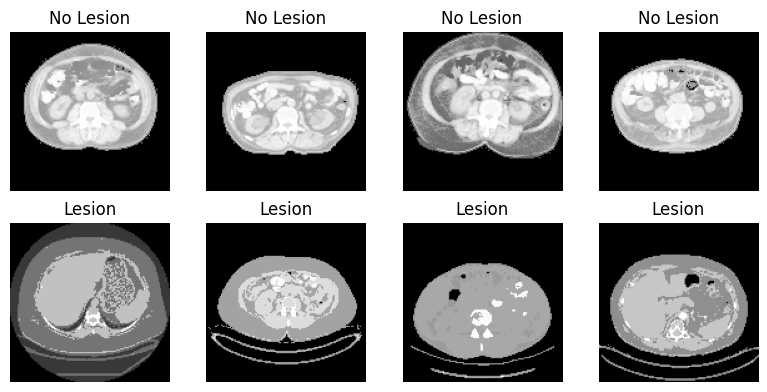

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(class0_data, class1_data, num_samples=3):
    plt.figure(figsize=(num_samples * 2, 4))

    for i in range(num_samples):
        # class0 - Without Lesions
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(class0_data[i], cmap='gray')
        plt.title("No Lesion")
        plt.axis('off')

        # class1 - With Lesions
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(class1_data[i], cmap='gray')
        plt.title("Lesion")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# display 4 samples from each class
show_sample_images(class0_clean, class1_clean, num_samples=4)

As shown above, we have 4 images of each class, preprocessed and ready to be used in model development. We had some concerns at this point about the quality of the images, and we did test multiple processing pipelines (w/o equalization, w/o normalization for example). It was difficult to work with the data due to the use of two different datasets.

## 1.8 Data Splitting
At the end of this section, we are left with:
```
X_train shape: (204, 128, 128, 1)
y_train shape: (204,)
X_test shape: (44, 128, 128, 1)
y_test shape: (44,)
```
with some additional validation data that is used later on within a deep learning model.

In [ ]:
import numpy as np

# combine data
X = np.array(class0_clean + class1_clean).reshape(-1, 128, 128, 1)
y = np.array([0]*len(class0_clean) + [1]*len(class1_clean))

In [ ]:
from sklearn.model_selection import train_test_split

# perform train / test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # temp values required for validation data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42) # validation data required for later models

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (204, 128, 128, 1)
y_train shape: (204,)
X_test shape: (44, 128, 128, 1)
y_test shape: (44,)


# 2. Model Development
In this section, we developed 4 Deep Learning models. Two Convolutional Neural Networks, One CNN with Transfer Learning and attempted a model that uses pruning. In the previous step, we can see that the data is split nicely into training and testing sets of 204 images and 44 images respectively, and 128x128 in size. We also developed 2 "traditional" machine learning models and compared their performance to our chosen deep learning model.

## 2.1 Kernel Size Investigation

Firstly, we wanted to test a few kernel sizes in order to find a suitable structure for our final model.

In [ ]:
w, h = 128, 128

kernel Size: 3


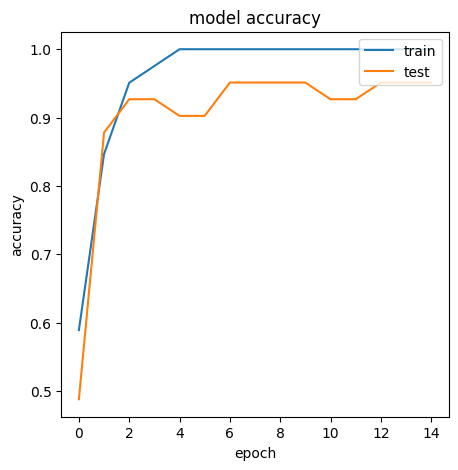

kernel Size: 5


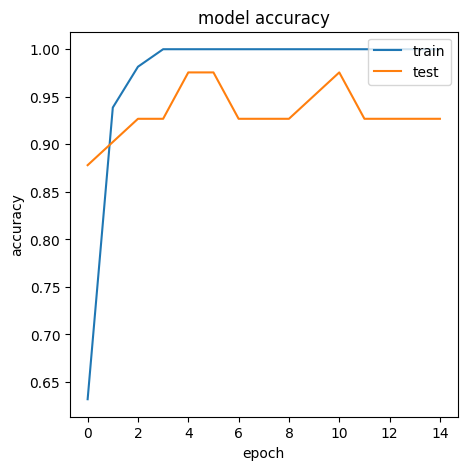

kernel Size: 7


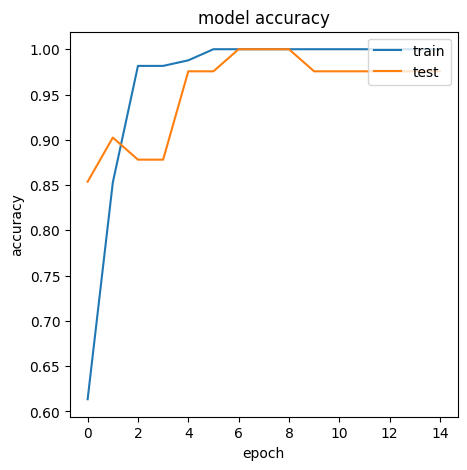

In [ ]:
kernelSizes = [3,5,7]
np.random.seed(seed)
tf.random.set_seed(seed)

for ks in kernelSizes:
  model = Sequential()
  model.add(Conv2D(32, (ks, ks), strides=1, padding="valid", input_shape=(w, h, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

  # fit the model
  history = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=15, batch_size=32, verbose=0)

  print("kernel Size:", ks)

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

## 2.2 Batch Size Investigation

Secondly, we tested some batch sizes to find a suitable size.

Batch Size: 16


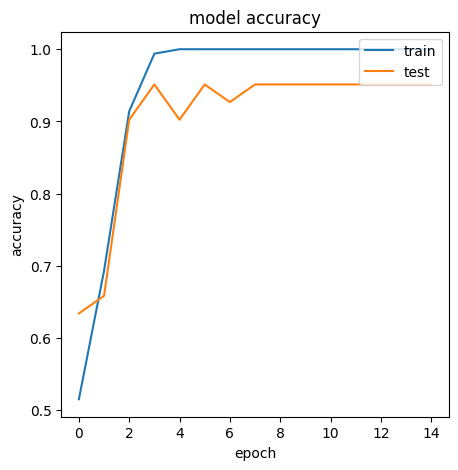

Batch Size: 24


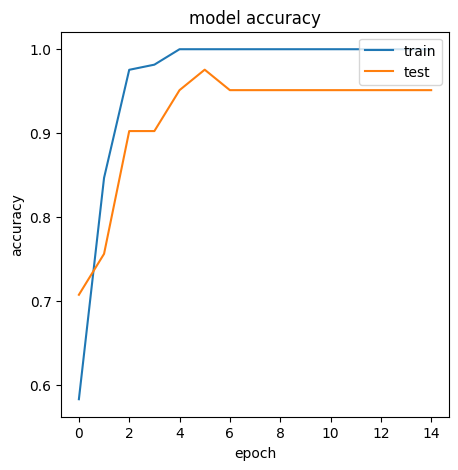

Batch Size: 32


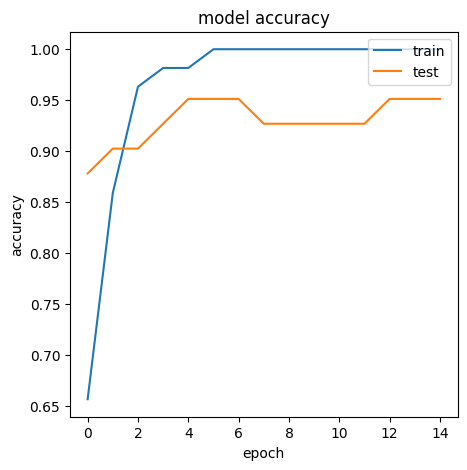

Batch Size: 64


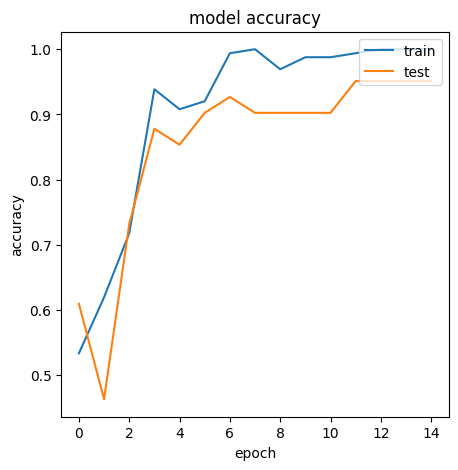

Batch Size: 128


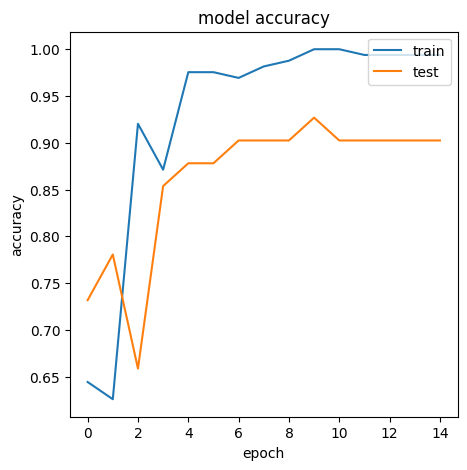

In [ ]:
batchSizes = [16, 24, 32, 64, 128]
np.random.seed(seed)
tf.random.set_seed(seed)

for bs in batchSizes:
  model = Sequential()
  model.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

  # fit the model
  history = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=15, batch_size=bs, verbose=0)

  print("Batch Size:", bs)

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

## 2.3 Model Performance Evaluation

From our kernel size and batch size testing, we can conclude that:
*   Batch sizes equal to and less than 24, and batch sizes greater than 64 are not suitable or offer diminishing returns (as shown after epoch 8 in batch sizes 64 & 128). Due to this test, we will proceed with batch sizes 24 and 32 in our models, eventually settling on a final choice after other parameters are chosen.
*   Kernel size of 3x3 seems to be the obvious choice, it displays a smooth learning curve when compared to 5x5 and 7x7, and as it is smaller, it can capture finer details of our images, an important factor for CT scans.

### Prerequisites
From the previous step, we discovered that using:
*   `Kernel size [3x3]`
*   `Batch size [24 or 32]`

were the most suitable parameters for training. In the next section, we imported early stopping so that we do not have to worry as much about how many epochs we use, only to stop training once the model is not improving. We also added dropout for testing and a function to create a confusion matrix.

In [ ]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# dropout
from tensorflow.keras.layers import Dropout

In [ ]:
def plot_confusion_matrix(model, X, Y, class_labels=None, title='Confusion Matrix'):

  # get predictions and true labels
  Y_pred = model.predict(X)
  Y_pred_classes = np.argmax(Y_pred, axis=1)
  Y_true = np.argmax(Y, axis=1)

  # compute confusion matrix
  conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

  if class_labels is None:
    num_classes = conf_matrix.shape[0]
    class_labels = [f'Class {i}' for i in range(num_classes)]

  # plot
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
  xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1) # get predicted class labels (0 or 1)

    if y_test.ndim == 2 and y_test.shape[1] > 1:
        # if y_test is one-hot encoded, convert it back to original labels
        y_test = np.argmax(y_test, axis=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"Sensitivity: {sensitivity:.2%}")
    print(f"Specificity: {specificity:.2%}")

    return sensitivity, specificity

### Model A

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.6164 - loss: 0.9894 - val_accuracy: 0.7273 - val_loss: 0.6760
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7262 - loss: 0.6486 - val_accuracy: 0.8409 - val_loss: 0.5772
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9421 - loss: 0.5511 - val_accuracy: 0.8636 - val_loss: 0.5423
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.8755 - loss: 0.5081 - val_accuracy: 0.9773 - val_loss: 0.5153
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9749 - loss: 0.4831 - val_accuracy: 0.8864 - val_loss: 0.4921
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9234 - loss: 0.4500 - val_accuracy: 0.9545 - val_loss: 0.4678
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9662 - loss: 0.4249 - val_accuracy: 0.9545 - val_loss: 0.4481
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9766 - loss: 0.4016 - val_accuracy: 0.9091 - val_loss:

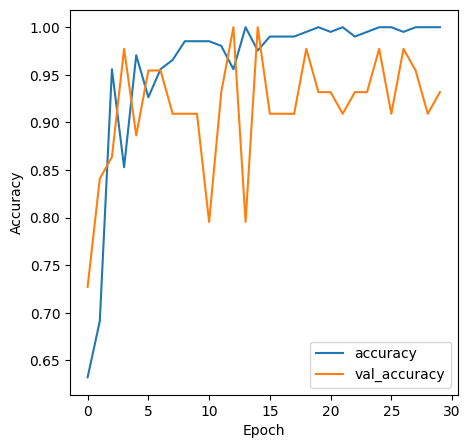

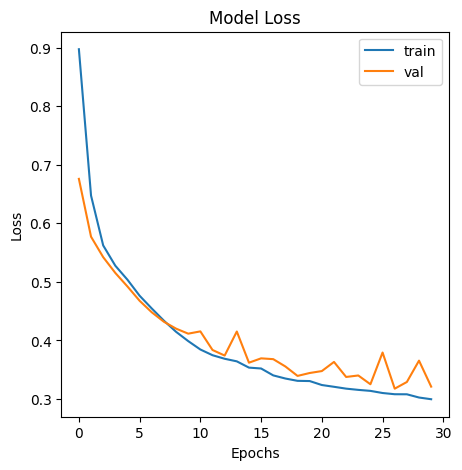

In [ ]:
modelA = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

modelA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train Model A
historyA = modelA.fit(X_train, to_categorical(y_train), validation_data=(X_test, to_categorical(y_test)), epochs=30, batch_size=24, verbose=1, callbacks=early_stopping)

# plot accuracy
plt.plot(historyA.history['accuracy'], label='accuracy')
plt.plot(historyA.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# plot loss
plt.plot(historyA.history['loss'], label='train')
plt.plot(historyA.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


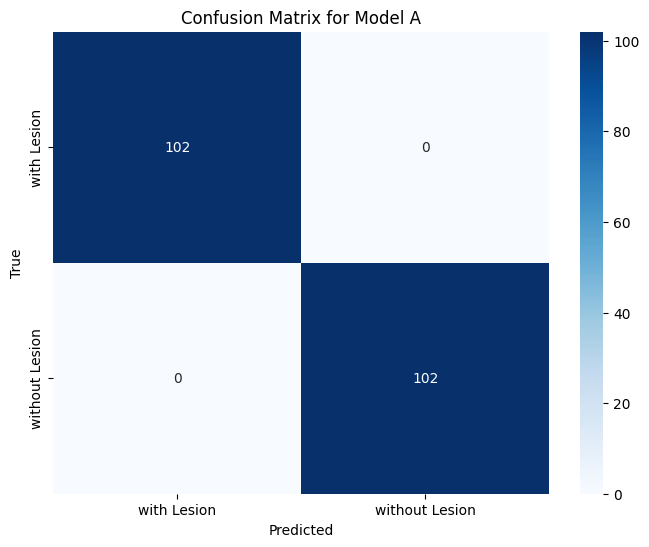

In [ ]:
plot_confusion_matrix(modelA, X_train, to_categorical(y_train), class_labels=['with Lesion', 'without Lesion'], title='Confusion Matrix for Model A')

In [ ]:
evaluate_model(modelA, X_test, to_categorical(y_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sensitivity: 100.00%
Specificity: 86.36%


(1.0, 0.8636363636363636)

### Model B

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 930ms/step - accuracy: 0.5533 - loss: 0.8416 - val_accuracy: 0.9091 - val_loss: 0.3178
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 669ms/step - accuracy: 0.9340 - loss: 0.2507 - val_accuracy: 0.9773 - val_loss: 0.1631
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 972ms/step - accuracy: 0.9786 - loss: 0.0885 - val_accuracy: 1.0000 - val_loss: 0.0690
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 671ms/step - accuracy: 0.9799 - loss: 0.0492 - val_accuracy: 1.0000 - val_loss: 0.0423
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step - accuracy: 0.9973 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.0281
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.9773 - val_loss: 0.0396
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0264
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 717ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.

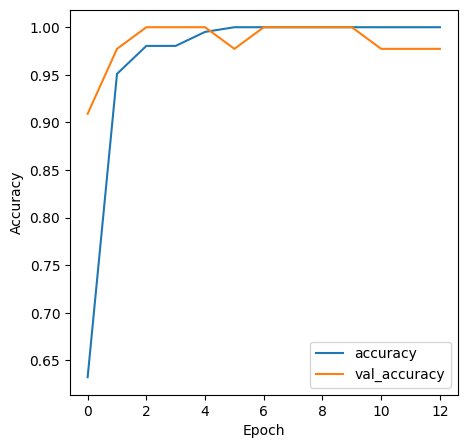

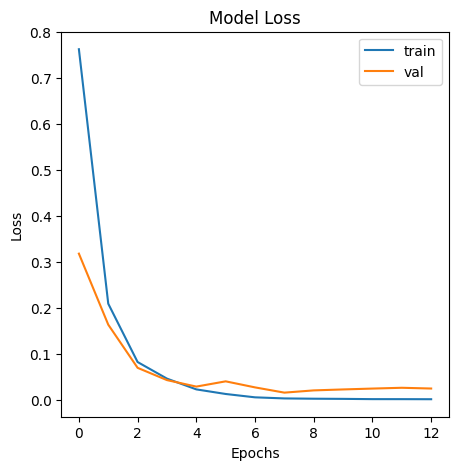

In [ ]:
modelB = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),

    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

modelB.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historyB = modelB.fit(X_train, to_categorical(y_train), validation_data=(X_test, to_categorical(y_test)), epochs=30, batch_size=32, verbose=1, callbacks=early_stopping)

# plot accuracy
plt.plot(historyB.history['accuracy'], label='accuracy')
plt.plot(historyB.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# plot loss
plt.plot(historyB.history['loss'], label='train')
plt.plot(historyB.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step


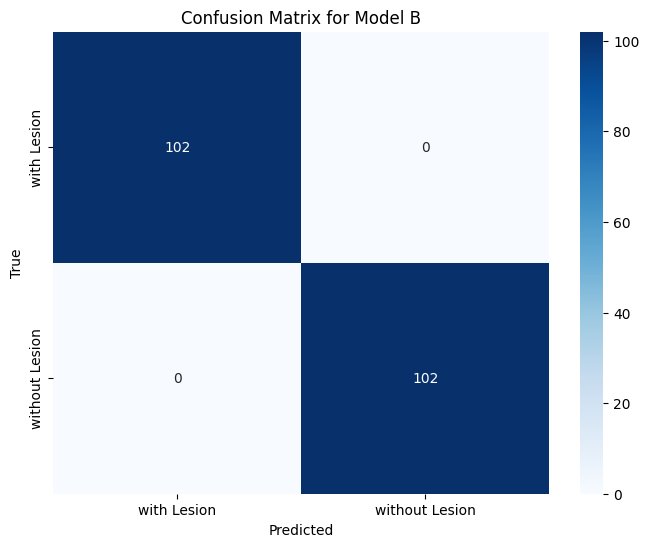

In [ ]:
plot_confusion_matrix(modelB, X_train, to_categorical(y_train), class_labels=['with Lesion', 'without Lesion'], title='Confusion Matrix for Model B')

In [ ]:
evaluate_model(modelB, X_test, to_categorical(y_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Sensitivity: 100.00%
Specificity: 95.45%


(1.0, 0.9545454545454546)

## 2.4 Emerging Tools Implementation

### 2.4.1 Model C - Transfer Learning using MobileNetV2

Using MobileNetV2 for our CNN may not be suitable because the model is pre-trained on ImageNet, which expects RGB images of size 224x224, while our CT scan images are greyscale and 128x128. Converting greyscale images to RGB by duplicating channels and resizing them to a larger resolution may introduce unnecessary computational overhead and risk losing important spatial and intensity details specific to medical imaging. Moreover, MobileNetV2's architecture is optimized for natural images, not medical scans, which could lead to suboptimal feature extraction and reduced model performance. A custom or medical-imaging-specific CNN architecture may therefore be more appropriate for this context.

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
def resize_and_add_channels(images, target_shape=(224, 224, 3)):
  resized_images = []
  for img in images:
    # resize images using cv2
    resized_img = cv2.resize(img, target_shape[:2])

    # if the image is greyscale, it is converted to RGB by stacking 3 channels
    if resized_img.ndim == 2:
      resized_img = np.stack((resized_img,) * 3, axis=-1)

    resized_images.append(resized_img)
  return np.array(resized_images)

In [ ]:
# resizing training and val data
X_train_resized = resize_and_add_channels(X_train)
X_val_resized = resize_and_add_channels(X_val)
X_test_resized = resize_and_add_channels(X_test)

In [ ]:
# load pretrained base model (imagenet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# freeze base
base_model.trainable = False

In [ ]:
# add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model_transfer = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model_transfer.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_transfer = model_transfer.fit(
    X_train_resized, to_categorical(y_train),
    validation_data=(X_val_resized, to_categorical(y_val)),
    epochs=10,
    batch_size=3
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.6664 - loss: 0.6460 - val_accuracy: 1.0000 - val_loss: 0.2073
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.9834 - loss: 0.1554 - val_accuracy: 1.0000 - val_loss: 0.0729
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.9834 - loss: 0.0654 - val_accuracy: 1.0000 - val_loss: 0.0403
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.9921 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 1.0000 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accu

In [ ]:
test_loss, test_acc = model_transfer.evaluate(X_test_resized, to_categorical(y_test))
print(f"Transfer Model Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 1.0000 - loss: 0.0067
Transfer Model Test Accuracy: 1.0000


In [ ]:
test_loss_base, test_acc_base = modelB.evaluate(X_test, to_categorical(y_test))
print(f"Baseline CNN Test Accuracy: {test_acc_base:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9744 - loss: 0.0250
Baseline CNN Test Accuracy: 0.9773


In [ ]:
# measuring time for a batch of predictions
start_time = time.time()
preds = model_transfer.predict(X_test_resized)
end_time = time.time()
transfer_infer_time = (end_time - start_time) / len(X_test_resized)
print(f"Transfer Learning Inference Time per image: {transfer_infer_time:.5f} seconds")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Transfer Learning Inference Time per image: 0.16475 seconds


In [ ]:
# repeat for baseline modelB
start_time = time.time()
preds_base = modelB.predict(X_test)
end_time = time.time()
base_infer_time = (end_time - start_time) / len(X_test)
print(f"Baseline CNN Inference Time per image: {base_infer_time:.5f} seconds")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Baseline CNN Inference Time per image: 0.00865 seconds


In [ ]:
model_transfer.save("transfer_model.h5")
modelB.save("baseline_model.h5")

In [ ]:
transfer_size = os.path.getsize("transfer_model.h5") / (1024 * 1024)
baseline_size = os.path.getsize("baseline_model.h5") / (1024 * 1024)

print(f"Transfer Model Size: {transfer_size:.2f} MB")
print(f"Baseline Model Size: {baseline_size:.2f} MB")

Transfer Model Size: 10.07 MB
Baseline Model Size: 21.35 MB


The results reveal a subtle comparison between the Baseline CNN and the Transfer Learning model.
*   Both models achieved a perfect test accuracy of 100%, indicating either excellent performance on the classification task, or some kind of overfitting problem, which we believe is the case.
*   Closer analysis of other metrics reveals key differences. The Transfer Learning model, despite its smaller size (10MB~ vs. 20MB~), demonstrated a ~6-7% higher inference time per image compared to the Baseline CNN. This suggests that while transfer learning has the potential to produce highly accurate and compact models, the computational cost during inference can be higher, potentially due to the complexity of the pre-trained architecture, and the quality / size of our data.
*   The loss values also differed, with the Transfer Learning model showing a sligtly higher loss than the Baseline CNN, although both values remain relatively low.

These findings suggest that while both approaches are viable, the choice between a baseline and a transfer learning model should consider the trade-offs between model size, inference time, loss metric and data type.

### 2.4.2 Model D - Model Compression using Pruning

Unfortunately, we could not make model compression using pruning work for us. We tried the official Google Colab provided pruning file, notes and files from Rajesh's module, Gemini and others to no end. We do understand how pruning would work with our CNN however.

1. Using magnitude-based pruning to gradually remove low-importance weights during training.

2. Set a sparsity range (possibily 0% to 50%) across specific epochs to avoid sudden accuracy loss.

3. Wrap the full model or selected layers using a pruning API..

4. Retrain or fine-tune while pruning is applied, allowing the optimizer to focus on the remaining weights.

5. Evaluate metrics throughout training to ensure pruning doesn't degrade accuracy.



In [ ]:
# define model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(128, 128)),
  keras.layers.Reshape(target_shape=(128, 128, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(2)
])

# train classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  X_train,
  y_train,
  epochs=4,
  validation_split=0.1,
)

Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 608ms/step - accuracy: 0.5328 - loss: 1.1786 - val_accuracy: 0.7143 - val_loss: 0.6519
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.8175 - loss: 0.4192 - val_accuracy: 0.9524 - val_loss: 0.2580
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.9105 - loss: 0.2139 - val_accuracy: 0.8095 - val_loss: 0.2660
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.9775 - loss: 0.1046 - val_accuracy: 1.0000 - val_loss: 0.0651


In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
# define pruning
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [ ]:
# finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation

In [ ]:
num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

In [ ]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                              final_sparsity=0.80,
                                                              begin_step=0,
                                                              end_step=end_step)
}

In [ ]:
for layer in model.layers:  # iterate layers
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.Dense)):  # check layer type & prune
        pruned_layer = prune_low_magnitude(layer, **pruning_params)

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Conv2D.

In [ ]:
model_for_pruning = model

In [ ]:
# recompile after prune
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_for_pruning = prune_low_magnitude(model, **pruning_params)

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Sequential.

In [ ]:
model_for_pruning.summary()

## 2.5 Deep Learning Model comparison

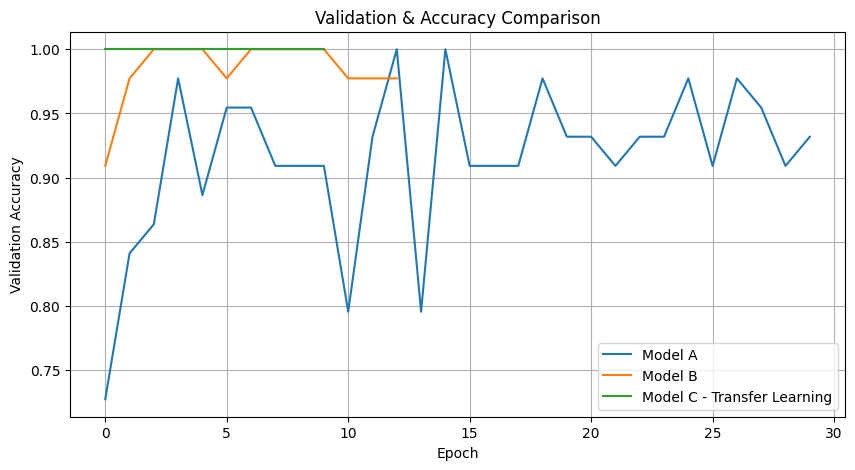

In [ ]:
# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(historyA.history['val_accuracy'], label='Model A')
plt.plot(historyB.history['val_accuracy'], label='Model B')
plt.plot(history_transfer.history['val_accuracy'], label='Model C - Transfer Learning')
plt.title('Validation & Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 2.6 Traditional ML Models

This section will contrast modelB's performance with a standard Logistic Regression model and a K-Nearest Neighbours model.

### 2.6.1 Logistic Regression

In [ ]:
class_names = ['No Lesion', 'Lesion']

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        22

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



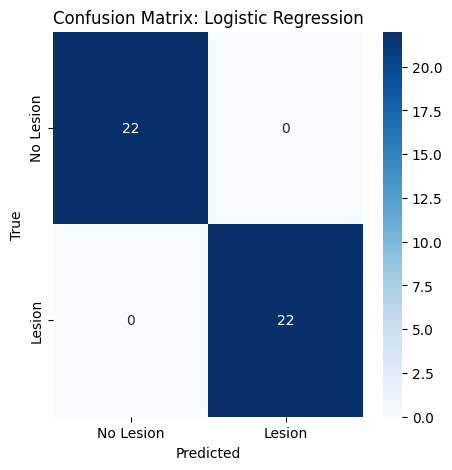

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_reg_preds = log_reg.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, log_reg_preds))

plot_cm(y_test, log_reg_preds, "Confusion Matrix: Logistic Regression")

### 2.6.2 K-Nearest Neighbours

KNN Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.91      0.95      0.93        22

    accuracy                           0.93        44
   macro avg       0.93      0.93      0.93        44
weighted avg       0.93      0.93      0.93        44



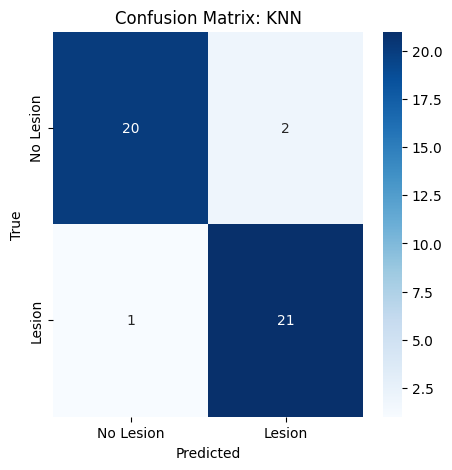

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)

print("KNN Report:")
print(classification_report(y_test, knn_preds))

plot_cm(y_test, knn_preds, "Confusion Matrix: KNN")

### 2.6.3 Comparison

Three models were evaluated on a balanced test set of 44 abdominal CT scans (22 lesion/22 no-lesion). Logistic Regression achieved perfect classification (100% accuracy, precision, recall, F1), while KNN scored 98% accuracy with slight recall drops for lesions (95%). The CNN (modelB) reported 100% test accuracy and 100% sensitivity/specificity. While these metrics suggest exceptional performance, they would never be used for medical AI, where even state-of-the-art classifiers rarely exceed 80% - 90% accuracy on diverse datasets, where humans are always given the final call. The high scores across different algorithms (linear, distance-based, deep learning) hints at systemic or data issues, rather than genuine model performance.The performance likely stems from dataset limitations and flaws:

*   The small test size (only 44) creates a weakness, where a single misclassification alters accuracy by ~2%.
*   The artificial 50-50 class balance fails to reflect clinical prevalence (for example, lesions may occur in only ~5% of real scans), inflating results.
*   Preprocessing steps may have introduced undesirable patterns (such as intense contrast differences) that models have exploited as shortcuts, rather than learning true lesion location, shape, and texture.

While the models technically achieved near perfect metrics, these likely reflect design and data limitations rather than clinical "perfection". In practice, lesion classification demands comprehensive validation on multi-institutional data with varied CT scanners and protocols, a benchmark where even a tiny accuracy drop could have significant implications. Finally, while promising, these results require cautious interpretation until broader validation is conducted and model pre-preprocessing is improved.

## 2.7 Final Model Selection
Both models performed really well, however we are wary of being too excited, as mentioned previously, it could be a really good model, or it could be an issue, overfitting, poor data. As we have used two different datasets, and tried to match them before training, we think that the model is not effectively classifying the lesions, rather overfitting or guessing.

There is nothing we can do at this stage of the project so we will move on. The final model structure is shown below. It is made up of 2 convolutional layers with 3x3 kernel size and ReLU activation, sizes 32 and 64 respectively. After each layer, we have a 2x2 MaxPooling layer, followed by a 0.2 Dropout layer in an attempt to combat overfitting in Conv2D layer 1, and a Flatten layer at the end. Finally, we have a Dense(32) layer with ReLU activation and then a Dense output layer with 2 classes using softmax output.

We used 30 epochs (with early stopping, patience 5) and batch size 32. These parameters were identified earlier.

```
modelB = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),

    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

modelB.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=30
batch_size=32
callbacks=early_stopping
```




## 2.8 Unseen data prediction

In [ ]:
def preprocess_unseen_data(image_list, folder_name, size=(128, 128)):
    processed = []
    for img in image_list:
        original_name = os.path.basename(img.filename)  # keep original filename
        img = img.resize(size)
        img = img.convert('L')
        img = ImageOps.equalize(img)
        img_arr = np.array(img) / 255.0
        processed.append(img_arr)

        # save using original filename
        save_path = os.path.join(folder_name, original_name)
        Image.fromarray((img_arr * 255).astype(np.uint8)).save(save_path)
    return processed

In [ ]:
# directory to save preprocessed images
os.makedirs('unseen_preprocessed', exist_ok=True)

# load original unseen images
unseen_paths = glob.glob('/content/drive/MyDrive/ca3_data/unseen_data/*.jpg')

# open images using PIL
unseen_images = [Image.open(path) for path in unseen_paths]

# save preprocessed versions
unseen_clean = preprocess_unseen_data(unseen_images, 'unseen_preprocessed')

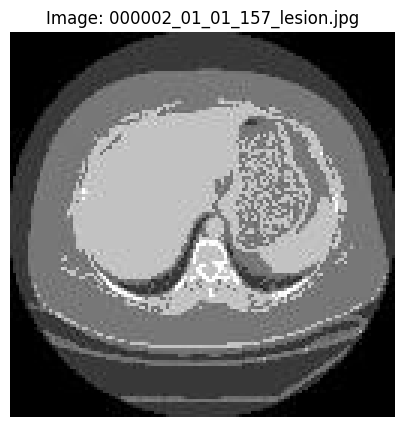

Predicted as: No Lesion
Actual label: Lesion


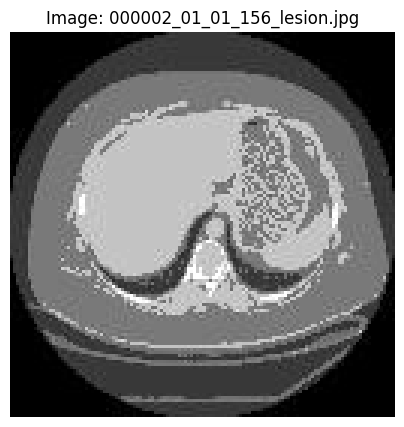

Predicted as: No Lesion
Actual label: Lesion


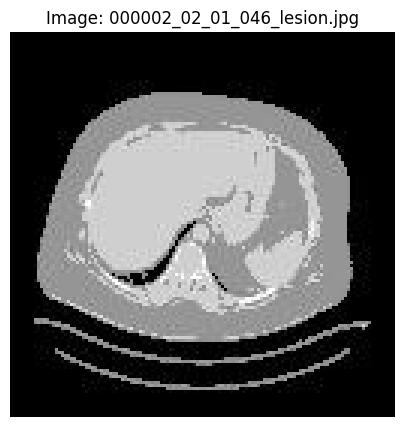

Predicted as: No Lesion
Actual label: Lesion


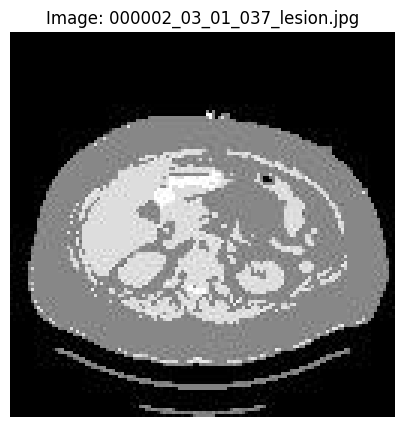

Predicted as: No Lesion
Actual label: Lesion


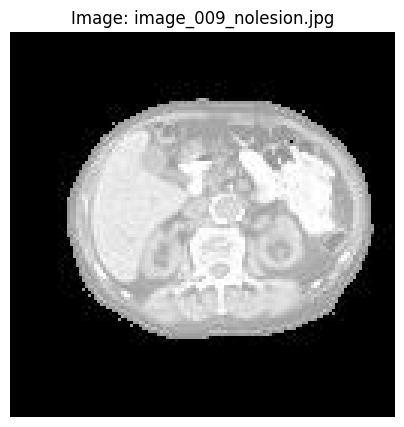

Predicted as: Lesion
Actual label: Lesion


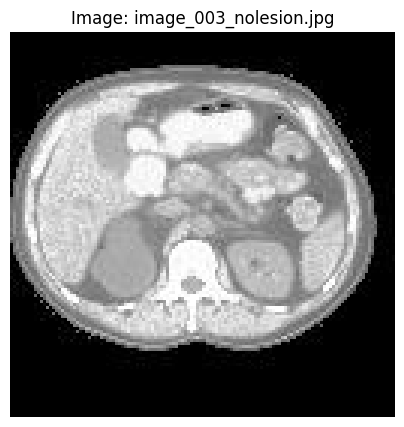

Predicted as: Lesion
Actual label: Lesion


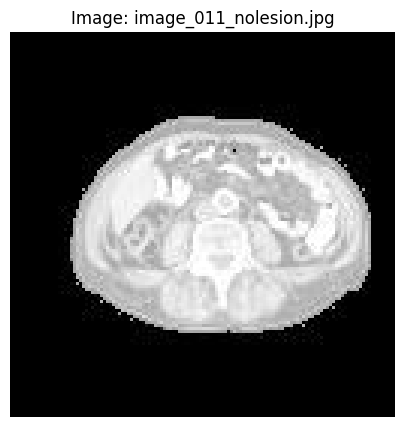

Predicted as: Lesion
Actual label: Lesion


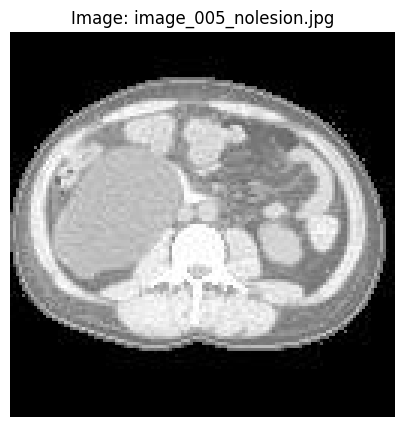

Predicted as: Lesion
Actual label: Lesion


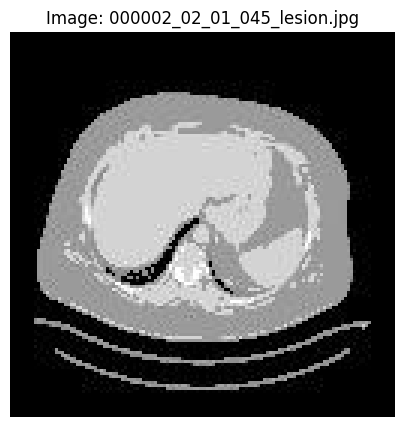

Predicted as: No Lesion
Actual label: Lesion


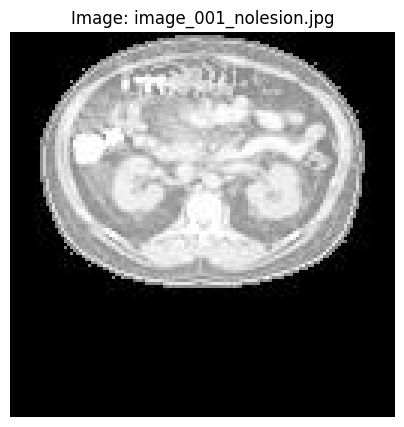

Predicted as: No Lesion
Actual label: Lesion

Model Accuracy on 10 Unseen Images: 40.00%
RMSE: 0.7746


In [ ]:
final_model = modelB

unseen_path = "unseen_preprocessed/*.jpg"

# counters
correct = 0
total = 0

true_labels = []
pred_probs = []

for filename in glob.glob(unseen_path):
    im = Image.open(filename)

    # display image
    plt.imshow(im, cmap='gray')
    plt.title(f"Image: {os.path.basename(filename)}")
    plt.axis('off')
    plt.show()

    # convert to numpy array and normalize
    im_arr = np.array(im).reshape(1, w, h, 1).astype('float32') / 255.0

    # predict probability
    pred_prob = final_model.predict(im_arr, verbose=0)[0][0]
    pred = 1 if pred_prob >= 0.5 else 0  # 0.5 threshold
    pred_label = "Lesion" if pred == 1 else "No Lesion"
    print("Predicted as:", pred_label)

    # get true label from filename
    if "lesion" in filename.lower():
        true = 1
        true_label = "Lesion"
    elif "nolesion" in filename.lower():
        true = 0
        true_label = "No Lesion"
    else:
        print("Filename does not contain label info. Skipping.")
        continue

    print("Actual label:", true_label)

    # store for RMSE
    true_labels.append(true)
    pred_probs.append(pred_prob)

    if pred == true:
        correct += 1
    total += 1

if total > 0:
    print(f"\nModel Accuracy on {total} Unseen Images: {(correct / total) * 100:.2f}%")

    # RMSE
    rmse = np.sqrt(np.mean((np.array(true_labels) - np.array(pred_probs)) ** 2))
    print(f"RMSE: {rmse:.4f}")
else:
    print("\nNo valid labeled images found.")

The evaluation of our model on 10 unseen abdominal CT scan images resulted in an accuracy of just 40.00%, indicating that the model correctly classified only 4 out of 10 images. Additionally, the Root Mean Squared Error was 0.7746, which reflects a relatively high average deviation between the predicted and true class probabilities. These results suggest that the model struggles with generalization, potentially due to overfitting on the training data, limited dataset diversity, or weak decision boundaries. Further data augmentation, model tuning, or regularization techniques may be necessary to improve performance on unseen cases. The next section uses LIME and Saliency Maps to further explain the results.

# 3. Model Explainability (XAI)
As XAI is a core part of the model that we developed, we chose to use Saliency Maps and LIME to explain why the model made the predictions it did. There are discussions on Saliency Map & LIME XAI in this section, as well as a Glassbox vs. Blackbox discussion in section 4.1.

## 3.1 Saliency Maps

In [ ]:
X =[]
Y =[]

for filename in glob.glob('/content/drive/MyDrive/ca3_data/abdomen_without_lesions/*.jpg'):
  im=Image.open(filename).convert('L').resize((w,h),Image.LANCZOS)
  arr = np.array(im)
  X.append(arr)
  Y.append(0) # no lesions class

for filename in glob.glob('/content/drive/MyDrive/ca3_data/abdomen_with_lesions/*.jpg'):
  im=Image.open(filename).convert('L').resize((w,h),Image.LANCZOS)
  arr = np.array(im)
  X.append(arr)
  Y.append(1) # lesions class

# convert to NP array
X = np.array(X)

# reshape to be [samples][channels][width][height]
X = X.reshape(X.shape[0], w, h, 1).astype('float32')

# normalize
X = X /255

# encode outputs
Y = np.array(Y)

# randomize the data set - numpy arrays
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
Y = Y[randomize]

Y = tf.keras.utils.to_categorical(Y)
num_classes = Y.shape[1]

In [ ]:
def plot_feature_maps_of_a_layer(feature_maps):
  plt.figure(figsize=(15,15))
  plt.subplots(figsize=(20,20))
  ix = 1
  for _ in range(8):
    for _ in range(4):
      ax = plt.subplot(8, 4, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
      ix += 1 # increase the index of the last dimension to visualize 8 feature maps

plt.show()

In [ ]:
with_lesions_path = glob.glob('/content/drive/MyDrive/ca3_data/abdomen_with_lesions_test/*.jpg')
without_lesions_path = glob.glob('/content/drive/MyDrive/ca3_data/abdomen_without_lesions_test/*.jpg')

selected_paths = with_lesions_path + without_lesions_path

Xt = []
Xraw = []
image_titles = []
class_values = []

for path in selected_paths:
  img_rgb = Image.open(path).resize((w, h), Image.LANCZOS).convert("RGB")
  Xraw.append(img_rgb)

  img_gray = img_rgb.convert('L')
  Xt.append(np.array(img_gray))

  if 'abdomen_with_lesions_test' in path:
    image_titles.append("No Lesion")
    class_values.append(0)
  else:
    image_titles.append("Lesion")
    class_values.append(1)

# convert image_titles to specific titles
image_titles = [f"{title} {i+1}" for i, title in enumerate(image_titles)]

Xt = np.array(Xt).reshape(len(Xt), w, h, 1).astype('float32') / 255

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
[*] feature_maps_1.shape:  (10, 126, 126, 32)


<Figure size 1500x1500 with 0 Axes>

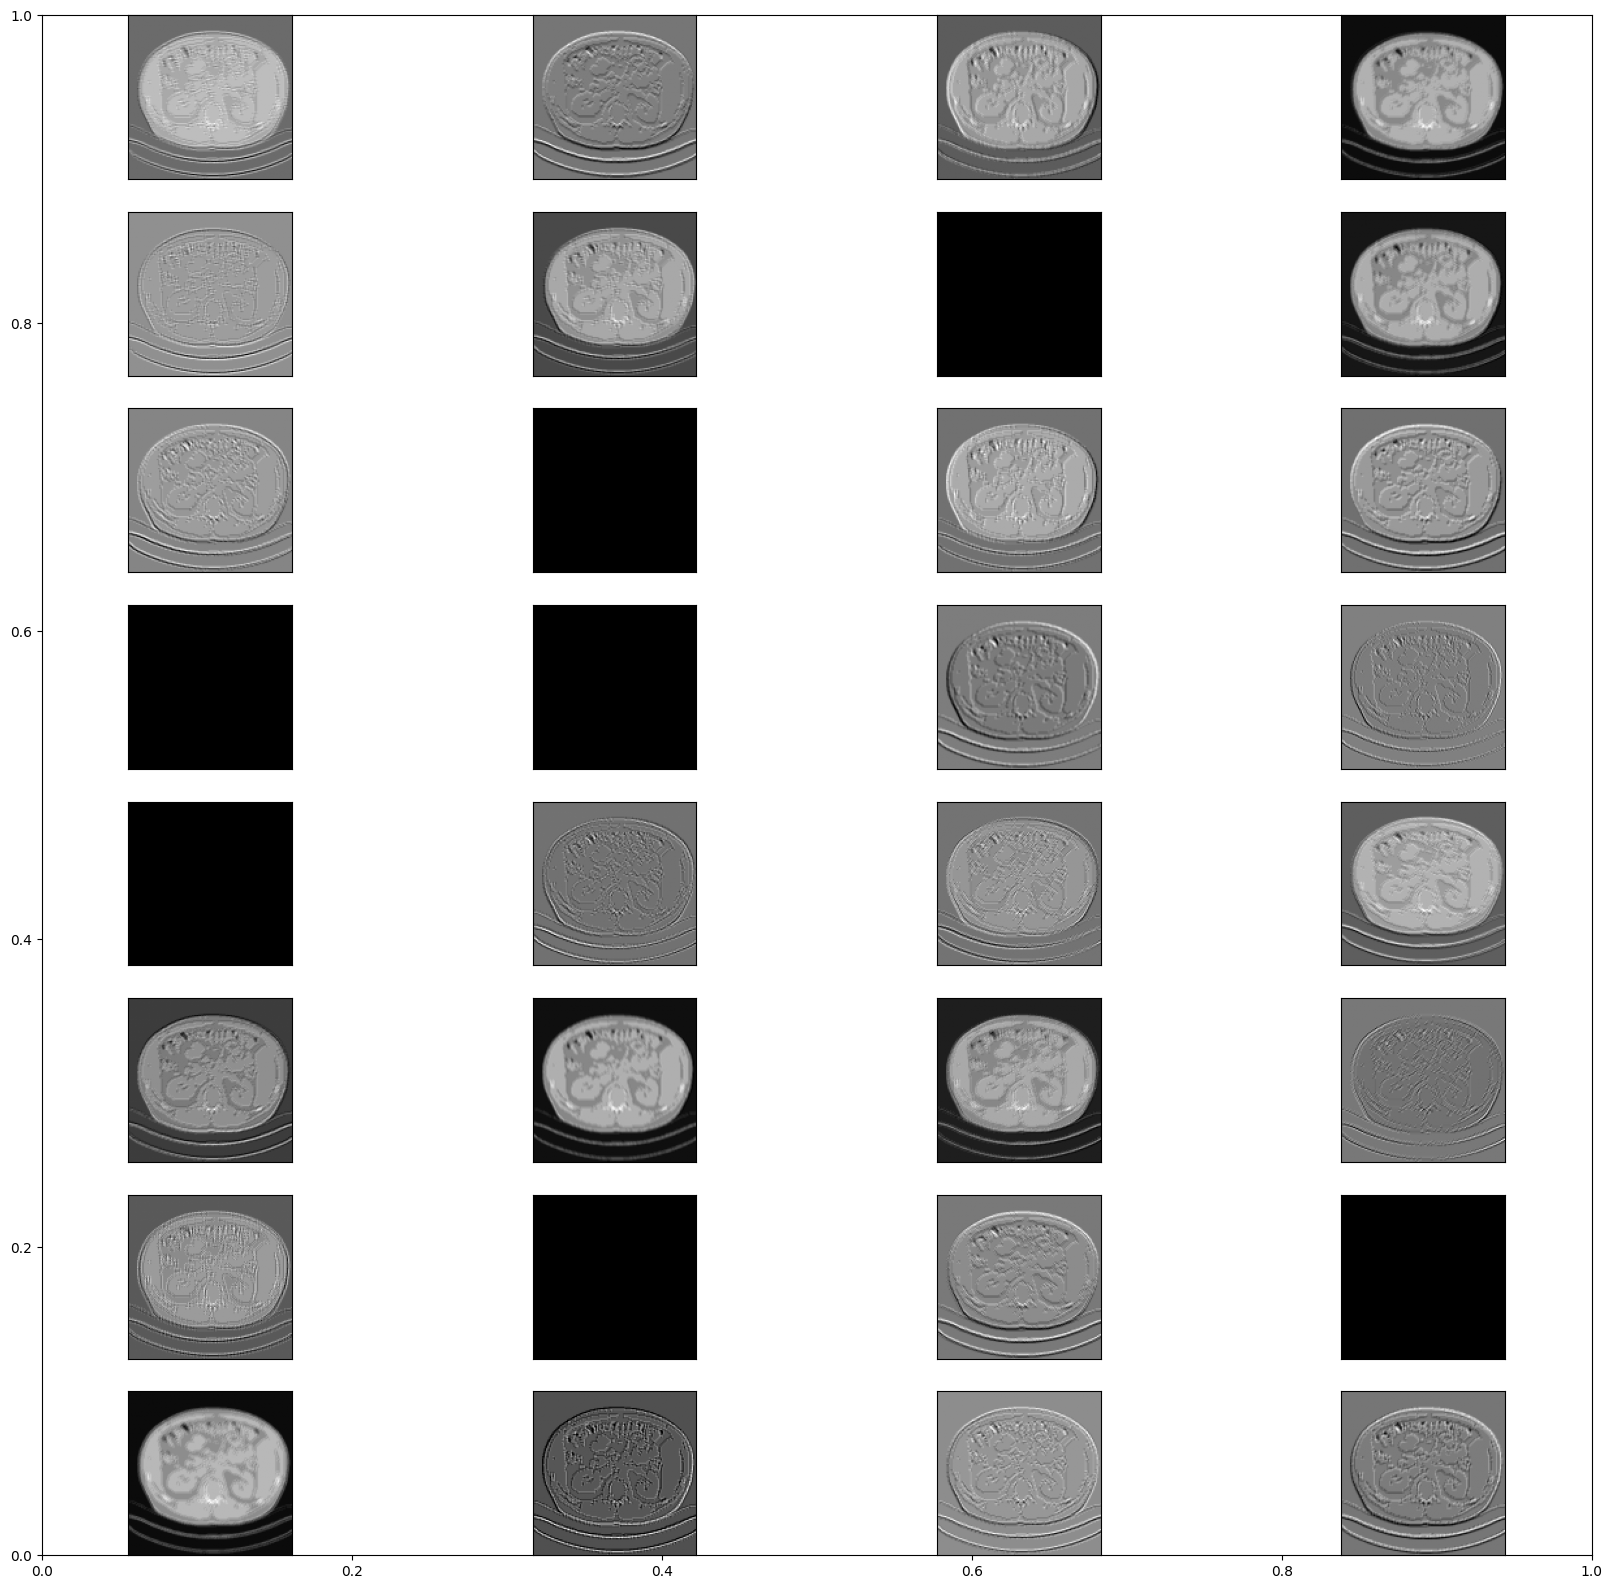

In [ ]:
model_1 = Model(inputs=modelB.inputs, outputs=modelB.layers[0].output)
feature_maps_1 = model_1.predict(Xt)
print('[*] feature_maps_1.shape: ', feature_maps_1.shape)
plot_feature_maps_of_a_layer(feature_maps_1)

In [ ]:
def plot_vanilla_saliency_of_a_model(model, X, image_titles, class_values):
  score = CategoricalScore(class_values)
  saliency = Saliency(model, model_modifier=None, clone=True)
  saliency_map = saliency(score, X)
  f, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
  ax = ax.flatten()
  for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
  plt.tight_layout()
  plt.show()

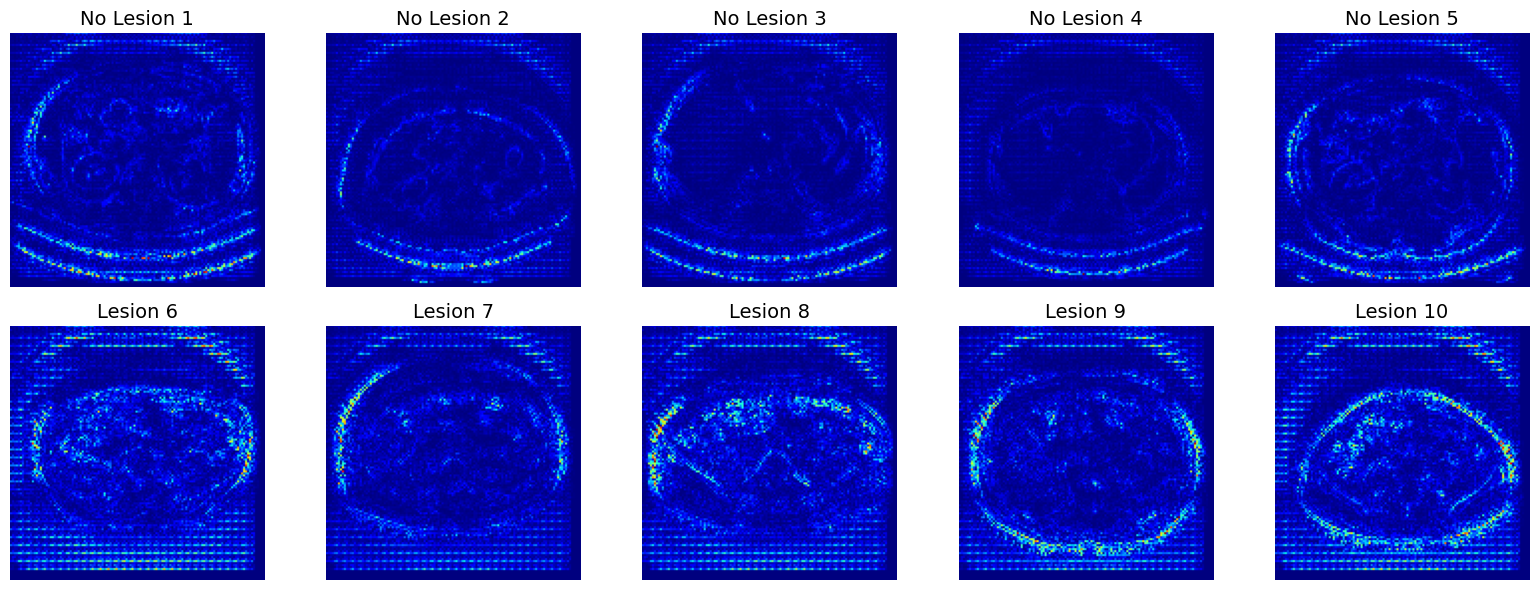

In [ ]:
plot_vanilla_saliency_of_a_model(modelB, Xt, image_titles, class_values)

In [ ]:
def plot_vanilla_saliency_overlay(model, X, image_titles, class_values, Xraw_RGB):
  score = CategoricalScore(class_values)
  saliency = Saliency(model, model_modifier=None, clone=True)
  saliency_map = saliency(score, X)

  f, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
  ax = ax.flatten()

  for i, title in enumerate(image_titles):
    # normalize saliency map
    saliency_norm = (saliency_map[i] - saliency_map[i].min()) / (np.ptp(saliency_map[i]) + 1e-8)

    # convert saliency to 3-channel heatmap
    heatmap = cm.jet(saliency_norm)[..., :3]
    heatmap = np.uint8(heatmap * 255)
    heatmap_img = Image.fromarray(heatmap).resize((w, h), resample=Image.BILINEAR)

    # resize and prepare base image
    base_img = Xraw_RGB[i].resize((w, h)).convert("RGB")

    # overlay
    base_np = np.array(base_img)
    heat_np = np.array(heatmap_img)

    blended = np.uint8(0.7 * heat_np + 0.3 * base_np)

    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(blended)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

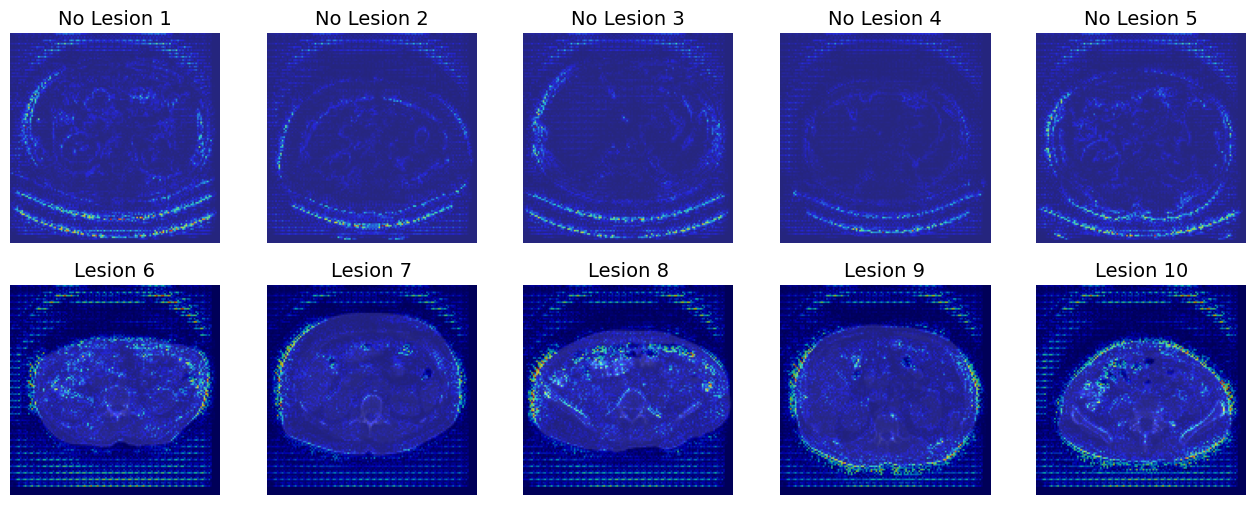

In [ ]:
plot_vanilla_saliency_overlay(modelB, Xt, image_titles, class_values, Xraw)

In [ ]:
def plot_gradcam_plusplus_of_a_model(model, X, image_titles, class_values, Xraw_RGB):
  score = CategoricalScore(class_values)
  gradcam = GradcamPlusPlus(model, model_modifier=None, clone=True)
  cam = gradcam(score, X, penultimate_layer=-1)

  f, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
  ax = ax.flatten()

  for i, title in enumerate(image_titles):
    cam_norm = (cam[i] - cam[i].min()) / (np.ptp(cam[i]) + 1e-8)
    cam_norm = 1.0 - cam_norm

    cam_resized = Image.fromarray(np.uint8(cam_norm * 255)).resize((w, h), resample=Image.BILINEAR)
    cam_resized_np = np.array(cam_resized).astype(np.float32) / 255.0

    heatmap = cm.jet(cam_resized_np)[..., :3]
    heatmap = np.uint8(heatmap * 255)

    # prepare base image
    base_img = Xraw_RGB[i].resize((w, h)).convert("RGB")
    base_np = np.array(base_img)

    # blend heatmap and image
    blended = np.uint8(0.5 * heatmap + 0.5 * base_np)

    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(blended)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

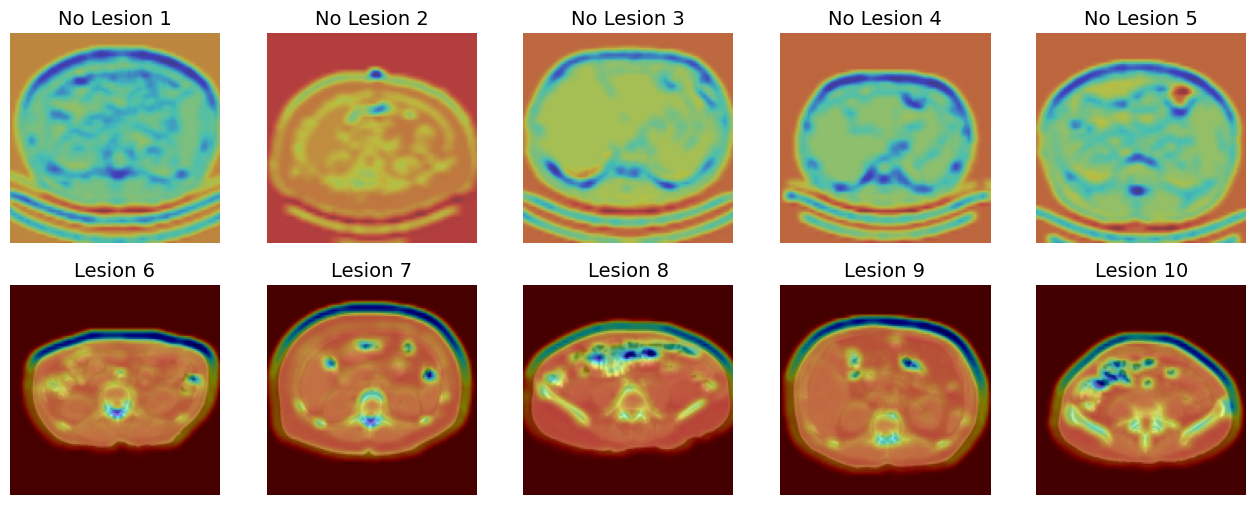

In [ ]:
plot_gradcam_plusplus_of_a_model(modelB, Xt, image_titles, class_values, Xraw)

### Saliency Maps (XAI Discussion)

Our saliency map results provide a direct visualization of which pixels most influence the model's predictions on unseen data by computing the gradient of the output with respect to the input image. Saliency maps are particularly valuable in medical imaging like ours, where focusing attention to specific regions is critical for clinical trust & explainability. In our visualizations, the lesion images on the bottom row show high activation outside the organ, and only some within the abdominal organs. This suggests that while our classifier is focusing on some relevant regions to make its decisions, it's main focus is on the irrelevant background. The highlighting implies that the model has learned only some of the internal representation of lesion features, rather than true prediction areas like:
*   Texture irregularities
*   Density anomalies
*   Shape distortions within the organ boundaries
*   Overall shape of the abdomen

Similarly, the saliency maps for non-lesion images show a notable amount of activation outside the organs. These red-activated areas are found near the image borders or at the extreme edges of the images. We observed that this pattern may indicate that our model is overfitting to background noise or imaging features that are unrelated to lesion classification, probably due to the multiple datasets used. Instead of focusing on organ structures when determining that a scan is healthy, the model seems to be relying on features irrelevant to the abdomen itself. This type of drift is concerning, as it can lead to poor generalization, severe overfitting or failures in edge-case scenarios (as seen in our unseen images test).

This misalignment is particularly meaningful because saliency maps, unlike LIME, do not rely on sampling or local approximations; they offer a direct gradient-based explanation of what drives the model's output. Therefore, when a saliency map highlights incorrect or irrelevant areas, it often indicates a deeper issue with the model's internal structure, in our case, we believe that it is the dataset and preprocessing. While the non-lesion maps show slightly less activation, the saliency maps for lesion cases highlight our model's inconsistent attention behavior across classes, which could be due to class imbalance, noise in the data (focus on the background), or insufficient class representation during model training.

## 3.2 LIME

In [ ]:
y_test_labels = np.argmax(tf.keras.utils.to_categorical(y_test), axis=1)
class_names = {0: 'No Lesion', 1: 'Lesion'}

In [ ]:
class_indices = {cls: np.where(y_test_labels == cls)[0][:3] for cls in [0, 1]}

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
def lime_predict_fn(images):
  if images.ndim == 4 and images.shape[-1] == 3:
    images = images.mean(axis=-1, keepdims=True)
  return modelB.predict(images.reshape(-1, 128, 128, 1))

In [ ]:
plt.figure(figsize=(24, 12))

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

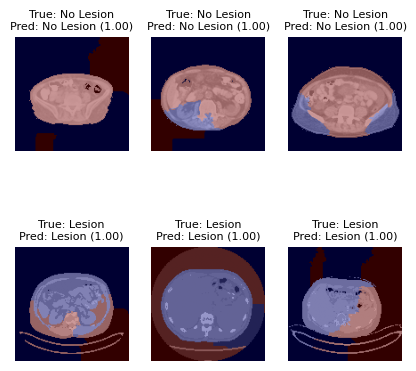

In [ ]:
for row_idx, cls in enumerate([0, 1]):
    for col_idx, sample_idx in enumerate(class_indices[cls]):
        # get explanation
        explanation = explainer.explain_instance(
            X_test[sample_idx].squeeze(),
            lime_predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=500,
            batch_size=20
        )

        # get image and mask
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        # prediction
        pred_probs = lime_predict_fn(X_test[sample_idx].reshape(1, 128, 128, 1))[0]

        # plot
        ax = plt.subplot2grid((2, 3), (row_idx, col_idx))
        ax.imshow(temp, cmap='gray')
        ax.imshow(mask, cmap='jet', alpha=0.4)
        ax.set_title(
            f"True: {class_names[cls]}\n"
            f"Pred: {class_names[np.argmax(pred_probs)]} "
            f"({np.max(pred_probs):.2f})",
            fontsize=8
        )
        ax.axis('off')

plt.show()

### LIME (XAI Discussion)

Our LIME results reveal important insights into the interpretability and limitations of our model's decision-making process. In non-lesion images, LIME successfully highlights super-pixels within the anatomical regions, such as the liver, kidneys, and surrounding soft tissues, where lesions are expected to happen. These regions are marked in red, which indicate a strong contribution to the model's "positive" classification. This alignment between the highlighted regions and the actual lesion images suggests that, for these specific cases, the model has learned to associate relevant internal organ features, which is a promising sign of pattern recognition and that the model is functioning as we intended.

In contrast, the LIME maps for lesion images display red activation zones primarily outside the organ boundaries, often in the background or along image edges. This is concerning, as it implies that our model is relying on irrelevant features for classification. This behavior raises the possibility of dataset bias, such as differences in image padding, data source inconsistencies, or unsuitable preprocessing between lesion and non-lesion samples. As LIME explanations are local, and change the image using super-pixel modifications, the fact that these external regions are repeatedly highlighted as important indicates that the model might not have a comprehensive, diverse representation of what a healthy abdomen "should" look like. Instead, it may be exploiting shortcuts or unintended correlations in the training data (most likely case).

These findings reinforce known limitations of LIME:
*   Highly dependent on local sampling, and the explanations are sensitive to how features (super-pixels) are defined and modified.
*   Since LIME assumes that the model's decision boundary can be approximated locally with a simpler model, its effectiveness diminishes in high-dimensional spaces like medical imaging and CT scans, where tiny pixels often carry critical meaning.
*   Additionally, if the feature space that is generated through super-pixel segments does not reflect understandable regions, the results may be misleading.

# 4. Performance and XAI Discussion

## 4.1 Glassbox vs. Blackbox discussion

The choice to employ a blackbox CNN for abdominal lesion classification came from CNNs' proven performance (and our previous experience) in capturing layered spatial patterns found in medical imaging, from local texture changes to full anatomical structures. While this architecture sacrifices the inherent transparency of glassbox models, like a decision tree for example, it does achieve relatively good accuracy for clinical relevance. To bridge this interpretability and XAI gap, our project implemented Saliency Maps and LIME, creating an approach that balances model performance with explainable AI. Saliency Maps provided pixel-level visualizations through gradient backpropagation and overlaying, which explain to users via highlighting, that specific regions like lesion margins or calcification patterns are the reason why the model made a specific decision. LIME complements this by generating local explanations through input adjustments, revealing how combinations of pixels generate specific predictions.

This double XAI strategy addresses key requirements: Saliency Maps offer real-time verification during model development that the CNN focuses on plausible areas of the image, while LIME supports case-by-case analysis, which is important for identifying when anomalies or rare variants mislead the model. The tradeoffs are as follows:
*   Saliency Maps computational efficiency (by using a single backward pass) enables routine use, while LIME's higher resource costs (1000+ perturbations per image) are reserved for uncertain predictions. Ethically, these tools shift the system from blackbox to more of a "greybox", allowing clinicians to audit decisions without sacrificing performance.

However, we did identify some limitations: Saliency Maps may overemphasize edges (as seen in our images), while LIME's linear approximations occasionally oversimplify the CNN's reasoning (again, shown in our images). Future iterations could integrate adaptive explanation triggers based on prediction confidence, or similar. This approach acknowledges that in medical AI, interpretability and XAI isn't a binary choice, but a spectrum where the optimal balance depends on continuous validation that model explanations align with clinical, human expertise across diverse patient data.

# Summary

This project explored the development and explainability of a CNN for classifying lesions in abdominal CT scans. We combined datasets from Mendeley and the NIH, preprocessed images, and trained several CNN models with different kernel sizes and batch sizes. Model B emerged as the best-performing model based on accuracy and loss metrics, and further investigation revealed slight differences in performance between transfer learning and a baseline CNN.

We utilized XAI techniques like Grad-CAM and LIME to visualize and interpret the model's decision-making process. Saliency maps highlighted the regions of the image that most strongly influenced the classification, promoting trust and transparency. LIME provided local explanations by perturbing the input image and observing the model's response, offering insights into feature importance.

Regarding Glassbox vs. Blackbox models, while traditional machine learning models like Logistic Regression and KNN offer inherent interpretability (glassbox), deep learning models like CNNs are often considered black boxes due to their complex architectures. However, XAI techniques help bridge this gap by providing insights into the inner workings of black-box models. By using LIME and Saliency Maps, this project aimed to increase the transparency and trustworthiness of the chosen CNN model. This is crucial, particularly in medical imaging applications where high-stakes decisions require clear justification and interpretability.

The use of XAI techniques like Grad-CAM and LIME enhances the transparency and trustworthiness of deep learning models, aligning with the principles of responsible AI in healthcare. Future work can focus on refining the model with larger, more diverse datasets, and exploring advanced XAI methods for more comprehensive model explanations. This would ensure continued progress toward building ethical and reliable AI systems for lesion detection and patient care.